In [10]:
import os
new_directory = '/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/'
os.chdir(new_directory)

from typing import Union, Tuple, Optional, Any, Dict, List
import numpy as np
import pickle
import yaml
import torch
from torch.utils.data import DataLoader, TensorDataset
import src.utils as utils
import src.gmm.modifiedgmm as mgmm
import src.sampler.fit_regressor as reg
import matplotlib.pyplot as plt
from src.sampler.LightCurveRandomSampler import LightCurveRandomSampler
from src.visualization import  plot_wall_lcs_sampling

import src.gmm.bgmm as bgmm 
from matplotlib.ticker import MaxNLocator, FormatStrFormatter


In [11]:
from src.utils import load_yaml_priors, load_pp_list, load_id_period_to_sample

with open('src/configuration/regressor.yaml', 'r') as file:
    config_file: Dict[str, Any] = yaml.safe_load(file)
vae_model: str =   config_file['model_parameters']['ID']  
data_sufix: str =   config_file['model_parameters']['sufix_path']  

print('Using vae model: '+ vae_model)
print(data_sufix)
PP_list = load_pp_list(vae_model)
PP_list

Using vae model: gn42liaz
GAIA3_LOG_IMPUTED_BY_CLASS_6PP
FEATURES:  ['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']


['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']

In [12]:
with open('src/configuration/paths.yaml', 'r') as file:
    YAML_FILE: Dict[str, Any] = yaml.safe_load(file)
PATHS: Dict[str, str] = YAML_FILE['paths']
PATH_PRIOS: str = PATHS['PATH_PRIOS']
mean_prior_dict: Dict[str, Any] = load_yaml_priors(PATH_PRIOS)

bgmm.fit_gaussians(priors=True, columns= ['Type','Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg'])


ACEP
{'CompleteName': 'Anomalous Cepheids', 'max_period': 2.5, 'min_period': 0.3, 'Binary': {'Period': [1, 10], 'teff_val': [5000, 6000], 'FeH_J95': [-0.1, 0.1], 'abs_Gmag': [0.5, 2.0], 'radius_val': [0.8, 1.5], 'logg': [3.5, 4.5], 'Midpoints': {'Period': 5.5, 'teff_val': 5500, 'FeH_J95': 0.0, 'abs_Gmag': 1.25, 'radius_val': 1.15, 'logg': 4}}, 'Ternary': {'Period': [5, 20], 'teff_val': [4500, 5600], 'FeH_J95': [-0.2, 0.2], 'abs_Gmag': [0.7, 2.5], 'radius_val': [1, 2], 'logg': [3, 4], 'Midpoints': {'Period': 12.5, 'teff_val': 5050, 'FeH_J95': 0.0, 'abs_Gmag': 1.6, 'radius_val': 1.5, 'logg': 3.5}}, 'Pulsating': {'Period': [0.5, 8], 'teff_val': [5200, 5800], 'FeH_J95': [-0.1, 0.1], 'abs_Gmag': [0.6, 1.8], 'radius_val': [0.9, 1.4], 'logg': [3.8, 4.2], 'Midpoints': {'Period': 4.25, 'teff_val': 5500, 'FeH_J95': 0.0, 'abs_Gmag': 1.2, 'radius_val': 1.15, 'logg': 4}}}
[[1.7047 8.6125 0.     1.25   0.1398 4.    ]
 [2.5257 8.5271 0.     1.6    0.4055 3.5   ]
 [1.4469 8.6125 0.     1.2    0.1398 4

In [13]:
plot_example=False
b=0.5
wandb_active=False
samples_dict = None
lb = []
n_samples = 8
PP = PP_list
priors = True
synthetic_samples_by_class = 8
 

In [14]:
gpu: bool = True 
with open('src/configuration/nn_config.yaml', 'r') as file:
    nn_config = yaml.safe_load(file)

class SyntheticDataBatcher:
    def __init__(self, config_file_path: str = 'src/configuration/regressor.yaml', 
                 nn_config_path: str = 'src/configuration/nn_config.yaml', paths: str = 'src/configuration/paths.yaml', PP=[], vae_model=None, 
                 n_samples=16, seq_length = 100, batch_size=128, prior=False):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.config_file = self.load_yaml(config_file_path)
        self.nn_config = self.load_yaml(nn_config_path)
        self.path = self.load_yaml(paths)['paths']
        self.mean_prior_dict = self.load_yaml(self.path['PATH_PRIOS'])  
        self.priors = prior
        self.PP = PP
        self.vae_model = vae_model
        self.n_samples = n_samples
        self.seq_length = seq_length
        self.delta_max = 100
        self.batch_size = batch_size

    @staticmethod
    def load_yaml(path: str) -> Dict[str, Any]:
        with open(path, 'r') as file:
            return yaml.safe_load(file)

        
    #TODO: implement function to phase light curves in order to validate revert function
    
    def construct_model_name(self, star_class: str, base_path: str = 'PATH_MODELS'):
        """Construct a model name given parameters."""
        file_name = f"{base_path}bgm_model_{str(star_class)}_priors_{self.priors}_PP_{len(self.PP)}.pkl"
        return file_name

    @staticmethod
    def count_subclasses(star_type_data: Dict[str, Any]) -> int:
        excluded_keys = ['CompleteName', 'min_period', 'max_period']
        return len([key for key in star_type_data.keys() if key not in excluded_keys])
    

    def fold_light_curve(self, array, period):
        # Check the type of 'array' and handle accordingly
        print(type(period))
        if 'LOG' in data_sufix: 
            period = torch.exp(period)
        period = period.cpu()
        period = period.reshape(period.shape[0], 1)
        if isinstance(array, np.ndarray):
            # If 'array' is a NumPy array, perform the operation directly
            array[:,0,:] = np.remainder(array[:,0,:], period) / period
        elif isinstance(array, torch.Tensor):
            # If 'array' is a PyTorch tensor, handle CUDA if necessary
            if array.is_cuda:
                array = array.cpu()
            array[:,0,:] = np.remainder(array[:,0,:].numpy(), period) / period
            array = torch.from_numpy(array)
            if torch.cuda.is_available():
                array = array.to('cuda')
        else:
            raise TypeError("Unsupported array type")

        return array

    
    @staticmethod
    def process_in_batches(model, mu_, times, onehot, phy, batch_size):

        total_samples = mu_.size(0)
        n_batches = (total_samples + batch_size - 1) // batch_size

        results = []
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, total_samples)

            mu_batch = mu_[start_idx:end_idx]
            times_batch = times[start_idx:end_idx]
            onehot_batch = onehot[start_idx:end_idx]
            phy_batch = phy[start_idx:end_idx]

            xhat_mu_batch = model.decoder(mu_batch, times_batch, label=onehot_batch, phy=phy_batch)
            results.append(xhat_mu_batch)
            del xhat_mu_batch
            torch.cuda.empty_cache()

        xhat_mu = torch.cat(results, dim=0)
        return xhat_mu
    
    @staticmethod
    def plot_light_curve(array, label_y = 'Magnitude', label_x='Time (MJD)'):
        fig, axis = plt.subplots(nrows=5, ncols=1, 
                             figsize=(5,12),sharex=False, sharey=False)
        axs = axis.flatten()
        for i in range(len(array)):
            axs[i].scatter(array[i][0], array[i][1], color='royalblue', s=4)
            #axs[i].invert_yaxis()  # Invert y-axis for each subplot


        
        axis[4].set_xlabel(label_x, fontsize=12)
        
        for ax in [0, 1, 2, 3, 4]:
            axis[ax].set_ylabel(label_y, fontsize=12)
            axis[ax].xaxis.set_major_locator(MaxNLocator(4))
            axis[ax].yaxis.set_major_locator(MaxNLocator(4))
            axis[ax].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            axis[ax].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            axis[ax].invert_yaxis()


        #plt.gca().invert_yaxis()
        #plt.tight_layout()
        plt.savefig('plot_'+label_y+label_x+'.png')
        plt.show()
        
    
    
    @staticmethod
    def attempt_sample_load(model_name: str, sampler: 'YourSamplerType', 
                            n_samples=nn_config['training']['synthetic_samples_by_class']) -> Tuple[Union[np.ndarray, None], bool]:
        try:
            samples = sampler.modify_and_sample(model_name, n_samples=n_samples, 
                                                mode= 'two_steps')
            return samples, True
        except Exception as e:
            raise Exception(f"Failed to load samples from model {model_name}. Error: {str(e)}")
    
    @staticmethod
    def load_encoder_vae(PATH_MODELS):
        with open(PATH_MODELS+'label_encoder_vae.pkl', 'rb') as f:
            label_encoder = pickle.load(f)
        return label_encoder
    
    def get_label_encodings(self, label_encoder, lb): 
        integer_encoded = label_encoder.transform(lb)
        n_values = len(label_encoder.classes_)
        onehot = np.eye(n_values)[integer_encoded]

        encoded_labels, _ = utils.transform_to_consecutive(integer_encoded, label_encoder)
        n_values = len(np.unique(encoded_labels))
        onehot_to_train = np.eye(n_values)[encoded_labels]
        onehot = torch.tensor(onehot, device=self.device)
        return onehot, onehot_to_train

    def create_time_sequences(self, lb, period):
        
        np.set_printoptions(suppress=True)
        times, original_sequences =  utils.get_only_time_sequence(n=1, star_class=lb, 
                                                                 period = period)
        times = np.array(times) 
        original_sequences = np.array(original_sequences) 
        times = torch.from_numpy(times).to(self.device)
        times = times.to(dtype=torch.float32)
        
        return times, original_sequences
    
    def batch_preprocessing(self, array):
        
        array = np.diff(array, axis=-1)
        mean_value = np.nanmean(array)
        array[(array)> self.delta_max] = mean_value 
        
        return array

    def save_batch(self, lc_reverted, onehot_to_train , PATH_DATA):
        
        utils.save_arrays_to_folder(lc_reverted, onehot_to_train , PATH_DATA)

        numpy_array_x = np.load(PATH_DATA+'/x_batch_pelsvae.npy', allow_pickle=True)
        numpy_array_y = np.load(PATH_DATA+'/y_batch_pelsvae.npy', allow_pickle=True)

        synth_data = utils.move_data_to_device((numpy_array_x, numpy_array_y), self.device)
        synthetic_dataset = TensorDataset(*synth_data)
        synthetic_dataloader = DataLoader(synthetic_dataset, batch_size=self.batch_size, shuffle=True)

        return synthetic_dataloader
    
    def create_labels(self, star_class, lb, samples_dict):
        if samples_dict==None:
            n_samples = self.n_samples
            lb += [star_class] * self.n_samples
        else: 
            n_samples = int(samples_dict[star_class])
            lb += [star_class] * n_samples

        return lb
    
    def get_all_labels(self, samples_dict):
        lb = []
        for star_class in list(self.nn_config['data']['classes']):
            torch.cuda.empty_cache()            
            lb = self.create_labels(star_class, lb, samples_dict)
        return lb
    
    def get_latent_space(self, all_classes_samples):
        z = reg.process_regressors(self.config_file, phys2=self.PP, samples= all_classes_samples, 
                                            from_vae=False, train_rf=False) 
        z = torch.tensor(z, device=self.device)
        return z

    def check_nan(self, lc_reverted):
        if np.sum(np.isnan(lc_reverted)) > 0:
            print(f"Number of NaN values detected: {np.sum(np.isnan(lc_reverted))}")
            raise ValueError("NaN values detected in lc_reverted array")
    
    def set_lc_length(self, oversampling, lc_reverted, n_oversampling, onehot_to_train):
        if oversampling: 
            sampler = LightCurveRandomSampler(lc_reverted, onehot_to_train, self.seq_length, n_oversampling)
            lc_reverted, onehot_to_train = sampler.sample()
        else:
            obs = lc_reverted.shape[2]
            print(obs)
            random_indexes = np.sort(np.random.choice(600, self.seq_length, replace=False))
            lc_reverted = lc_reverted[:, :, random_indexes]
        return lc_reverted, onehot_to_train
        
    def get_samples(self, samples_dict, PATH_MODELS, b):
        for star_class in list(self.nn_config['data']['classes']):

            if samples_dict==None:
                n_samples = self.n_samples
            else: 
                n_samples = int(samples_dict[star_class])

            print('------- sampling ' +star_class+'---------')
            components = self.count_subclasses(self.mean_prior_dict['StarTypes'][star_class])

            print(star_class +' includes '+ str(components) +' components ')

            sampler: mgmm.ModifiedGaussianSampler = mgmm.ModifiedGaussianSampler(b=b, 
                                                                                components=components, 
                                                                                features=self.PP)
            model_name = self.construct_model_name(star_class, PATH_MODELS)
            samples, error = self.attempt_sample_load(model_name, sampler, n_samples=n_samples)

            if samples is None:
                raise ValueError("The model can't be loaded." + str(error))

            if 'all_classes_samples' in locals() and all_classes_samples is not None: 
                all_classes_samples = np.vstack((all_classes_samples, samples))
            else: 
                all_classes_samples = samples

        return all_classes_samples
        
    
    def create_synthetic_batch(self, plot_example=True, b=1.5, 
                               wandb_active=False, samples_dict = None, 
                               oversampling = True, n_oversampling=12):
        
        PATH_MODELS = self.path['PATH_MODELS']
        PATH_DATA = self.path['PATH_DATA_FOLDER']

        label_encoder = self.load_encoder_vae(PATH_MODELS)
        
        lb = self.get_all_labels(samples_dict)
        
        onehot, onehot_to_train = self.get_label_encodings(label_encoder, lb)
        
        all_classes_samples = self.get_samples(samples_dict, PATH_MODELS, b)
        
        index_period = self.PP.index('Period')

        z = self.get_latent_space(all_classes_samples)
        
        lb = np.array(lb)  
        pp = torch.tensor(all_classes_samples, device=self.device)

        vae, _ = utils.load_model_list(ID=self.vae_model, device=self.device)
        
        times, original_sequences = self.create_time_sequences(lb, all_classes_samples[:,index_period])  

        xhat_mu = self.process_in_batches(vae, z, times, onehot, pp, 1)
        xhat_mu = torch.cat([times.unsqueeze(-1), xhat_mu], dim=-1).cpu().detach().numpy()

        integer = np.random.randint(0, 4)
        indices = [0+integer, 8+integer, 16+integer, 24+integer, 32+integer]#np.random.choice(xhat_mu.shape[0], 4, replace=False)
        print(xhat_mu.shape[0], indices)
        sampled_arrays = xhat_mu[indices, :, :]
        
        plot_wall_lcs_sampling(sampled_arrays, sampled_arrays,  cls=lb[indices], 
                                to_title = pp[indices], sensivity = 'Period', all_columns=self.PP, save=True, 
                                wandb_active=wandb_active) 

        lc_reverted = utils.revert_light_curve(pp[:,index_period], xhat_mu, original_sequences, classes = lb) 
        
        folded_synthetic_lc = self.fold_light_curve(lc_reverted[indices], pp[indices,index_period])
        
        if plot_example:
            self.plot_light_curve(lc_reverted[indices], label_y = 'Magnitude', label_x='Time (MJD)')
            self.plot_light_curve(folded_synthetic_lc, label_y = 'Magnitude', label_x='Phase')

        mean_value = np.nanmean(lc_reverted)
        lc_reverted[np.isnan(lc_reverted)] = mean_value

        lc_reverted, onehot_to_train = self.set_lc_length(oversampling, lc_reverted, n_oversampling, onehot_to_train)
        
        lc_reverted = self.batch_preprocessing(lc_reverted)

        if plot_example:
            self.plot_light_curve(lc_reverted[indices], label_y = r'$\Delta$ magnitude', label_x=r'$\Delta$ time')

        self.check_nan(lc_reverted)

        synthetic_dataloader = self.save_batch(lc_reverted, onehot_to_train , PATH_DATA)

        return synthetic_dataloader

In [15]:
batcher = SyntheticDataBatcher(PP = PP, vae_model=vae_model, n_samples=synthetic_samples_by_class, 
                                    seq_length = 300, prior=priors)

------- sampling CEP---------
CEP includes 4 components 
8
loading model:  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_CEP_priors_True_PP_6.pkl
BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([2.9114, 8.7853, 0.    , 0.    , 3.6217, 1.275 ]),
                        n_components=4, random_state=42)
[0.3002 0.5316 0.1437 0.0245]
Model loaded:  BayesianGaussianMixture(max_iter=5000,
                        mean_prior=array([2.9114, 8.7853, 0.    , 0.    , 3.6217, 1.275 ]),
                        n_components=4, random_state=42)
[[ 0.5993  8.665  -1.6403  4.9155 -0.0939  4.4338]
 [ 1.0975  8.725  -0.7562  2.68    0.8022  3.7881]
 [ 0.4876  8.6731 -3.7569  5.0842 -0.1665  4.4493]
 [ 1.6353  8.8945 -0.8155  0.39    1.6778  3.2459]]
mode:  two_steps
------- sampling DSCT---------
DSCT includes 2 components 
8
loading model:  /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/models/bgm_model_DSCT_priors_True_P

Selecting light curves: 100%|██████████| 40/40 [00:00<00:00, 182.17it/s]


40 [3, 11, 19, 27, 35]
Period: 1.33, teff_val: 8.64, [Fe/H]_J95: -0.95, abs_Gmag: 2.94, radius_val: 0.85, logg: 3.69
Period: -2.58, teff_val: 8.7, [Fe/H]_J95: -3.61, abs_Gmag: 6.07, radius_val: -0.7, logg: 4.82
Period: 0.35, teff_val: 8.47, [Fe/H]_J95: -1.79, abs_Gmag: 6.76, radius_val: -0.54, logg: 4.6
Period: 5.73, teff_val: 8.25, [Fe/H]_J95: 0.12, abs_Gmag: -2.38, radius_val: 4.61, logg: 0.67
Period: -0.8, teff_val: 8.6, [Fe/H]_J95: -1.67, abs_Gmag: 5.8, radius_val: -0.31, logg: 4.55
saving:  True


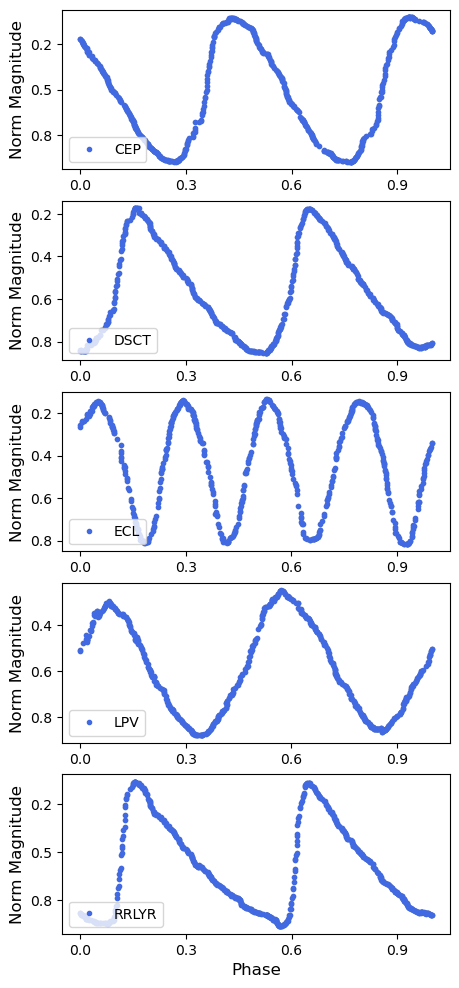

Getting time sequences: 100%|██████████| 40/40 [00:07<00:00,  5.70it/s]


tensor(0.4385, device='cuda:0')
tensor(0.9867, device='cuda:0')
tensor(1.3894, device='cuda:0')
tensor(1.3312, device='cuda:0')
tensor(1.4810, device='cuda:0')
tensor(1.4930, device='cuda:0')
tensor(0.8360, device='cuda:0')
tensor(1.1174, device='cuda:0')
tensor(-1.9853, device='cuda:0')
tensor(-2.0956, device='cuda:0')
tensor(-2.0004, device='cuda:0')
tensor(-2.5827, device='cuda:0')
tensor(-1.7550, device='cuda:0')
tensor(-2.0004, device='cuda:0')
tensor(-2.0730, device='cuda:0')
tensor(-2.0880, device='cuda:0')
tensor(1.4065, device='cuda:0')
tensor(1.0600, device='cuda:0')
tensor(0.7296, device='cuda:0')
tensor(0.3478, device='cuda:0')
tensor(-0.1335, device='cuda:0')
tensor(0.0735, device='cuda:0')
tensor(-1.4562, device='cuda:0')
tensor(0.7417, device='cuda:0')
tensor(5.7343, device='cuda:0')
tensor(5.5223, device='cuda:0')
tensor(5.7559, device='cuda:0')
tensor(5.7324, device='cuda:0')
tensor(6.1268, device='cuda:0')
tensor(5.9892, device='cuda:0')
tensor(5.7066, device='cuda:0'

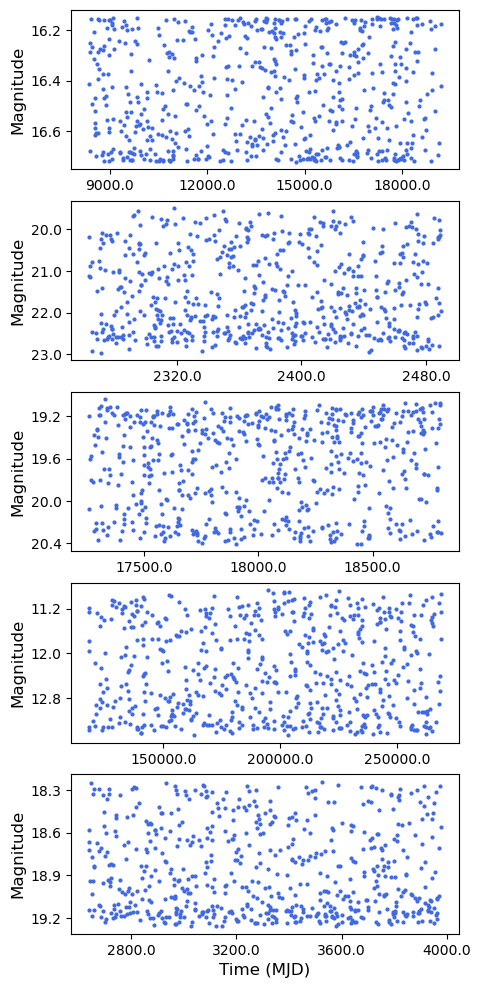

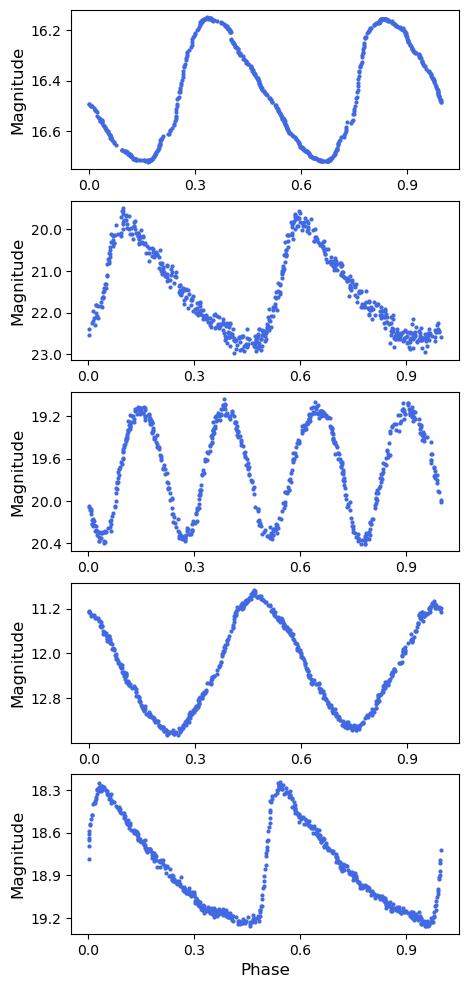

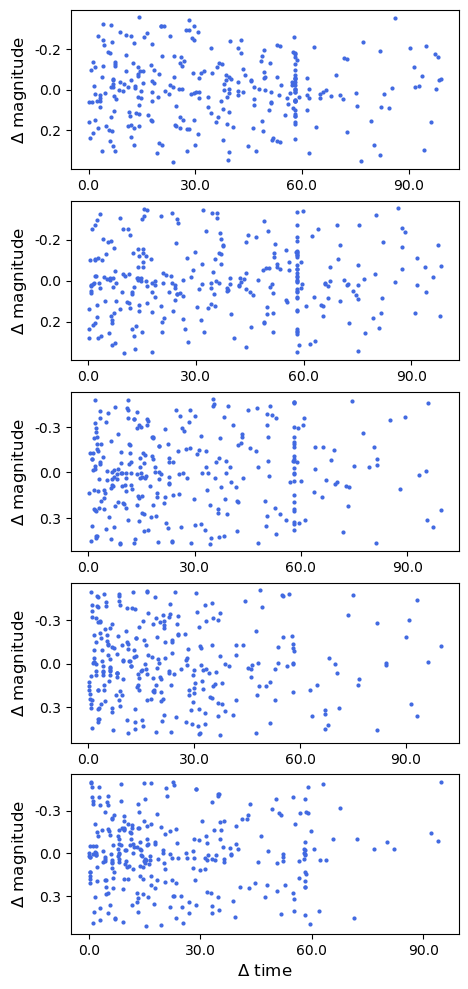

In [16]:
synthetic_data_loader = batcher.create_synthetic_batch(b=b, wandb_active=wandb_active, samples_dict = None)

In [17]:
synthetic_data_loader

In [18]:
for batch in synthetic_data_loader:
    # Process your data here
    print(batch)


[tensor([[[ 1.5649e-01,  5.6934e-01,  1.1567e+00,  ...,  3.1250e-02,
           3.8965e-01,  2.1436e-01],
         [ 7.0919e-01,  2.5877e-01, -3.6951e-01,  ..., -1.2199e+00,
           1.5824e+00, -1.5757e+00]],

        [[ 2.1650e+00,  7.2325e+01,  2.1533e+00,  ...,  8.8039e+01,
           6.1521e+01,  3.3326e+01],
         [-4.8752e-03, -7.5816e-02, -1.2836e-02,  ...,  5.3755e-02,
          -2.4612e-02,  1.0232e-01]],

        [[ 5.9293e+01,  3.1445e+00,  1.0786e+01,  ...,  9.2771e+01,
           1.1979e+01,  3.1992e+00],
         [ 2.0043e-01,  2.4551e-01, -4.0355e-01,  ..., -2.7382e-01,
           3.9259e-01, -3.1173e-01]],

        ...,

        [[ 6.9111e+00,  5.8089e+01,  4.0150e+01,  ...,  7.6141e+01,
           1.0318e+01,  3.7465e+01],
         [-2.7499e-01, -2.2221e-03,  5.3993e-02,  ..., -1.5290e-01,
          -6.6364e-02,  5.2092e-02]],

        [[ 5.8089e+01,  5.8089e+01,  4.2008e+01,  ...,  5.8089e+01,
           5.8089e+01,  5.8089e+01],
         [-1.2039e-01, -5.3606e-